## Инициализация

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
import os

mp.verbosity(0)
cmap = 'RdBu' # цветовая гамма графиков
foldername = 'inf beta'
file_name='two monitors try 6'
os.makedirs(foldername, exist_ok=True)
'''Физические параметры'''
Si = 3.4
air = 1
wl = 1.1 # central wavelength (micron)
fcen = 1/wl #central frequency
df = 0.05 # pulse width (in frequency)
df_q_mon = 0.01
df_p_mon = 0.01
r = wl/(Si*2*np.pi) * 16 # disk radius

angle = 45 # угол между краями углубления и центром диска (градусы)
distance = 0.2 # расстояние между краями диска и волновода (микроны)

wg_width = 0.5 # waveguide width (micron)
wg_center_y_f = lambda a, d: (r+d)*np.cos(np.radians(a/2)) + wg_width/2

'''Параметры симуляции'''
time = 500 # время симуляции после затухания источника
# Если время слишком маленькое, Harminv дает отрицательные Q
resolution = 40 # количество пикселей на один микрон
pad = 2 # padding between waveguide and edge of PML
pml_thickness = 0.5  # thickness of PML
nfreq = 100 # количество частот для подсчета мощности

sxy = int(2*(r + pad + pml_thickness))  # cell size
wg_size = mp.Vector3(sxy, wg_width, 0)
src_center = mp.Vector3(0, -0.9*r) # Координата источника
#flux_coord = r + pad - 0.1 # flux size and flux coordinate (удаленно от pml на 0.1 мкм)
flux_coord = sxy/2 - pml_thickness - 0.1
wg_center_y = wg_center_y_f(angle,distance)

'''Harminv мониторы'''
monitors = [mp.Vector3(0), 
            mp.Vector3(0,-0.25*r), 
            mp.Vector3(0,-0.5*r), 
            mp.Vector3(0,-0.75*r),
            mp.Vector3(0,-0.75*wl/Si*r),
            mp.Vector3(0,-1.25*r),]

monitors_names = ['Центр диска', 
                  '0.25r', 
                  '0.5r', 
                  '0.75r', 
                  '-0.75*wl/Si*r',
                  '1.25r']

harminv_monitors = [mp.Harminv(mp.Ez, mon, fcen, df_q_mon) for mon in monitors]


'''Инициализация'''
# has_wg=True строит диск с волноводом, has_wg=False - только диск (в этом случае angle и distance могут быть пустыми)
def init_geometry(has_wg, angle=None, distance=None):
    if has_wg:
        wg_center = mp.Vector3(0, wg_center_y_f(angle,distance), 0)
        geometry = [
            mp.Block(size=wg_size, center=wg_center, material=mp.Medium(index=Si)), # волновод
            mp.Cylinder(radius=r+distance, center=(0, 0, 0), material=mp.Medium(index=air)), # вырез в волноводе
            mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
        ] 
    else:
        geometry = [
        mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
        ] 
    return geometry

src = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df), 
                 mp.Ez, 
                 center = src_center,
                 size = mp.Vector3(0))
]

sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    sources=src,
    resolution=resolution,
    boundary_layers=[mp.PML(pml_thickness)],
    default_material=mp.Medium(index=air),
    symmetries=[mp.Mirror(direction=mp.X)],
)

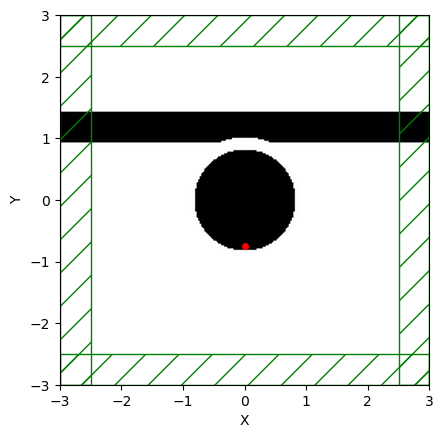

In [2]:
sim.geometry = init_geometry(has_wg=True, angle=angle, distance=distance)
sim.reset_meep()
sim.plot2D()
plt.show()

## Параметры оптимизации

In [2]:
'''Optimization'''

minimum_length = 0.09
eta_e = 0.55
#filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
#filter_radius = distance/4 #четверть зазора 
filter_radius = minimum_length
eta_i = 0.5
eta_d = 1 - eta_e
design_region_resolution = int(resolution)
design_region_width = 2*(r+wg_width/2)
design_region_height = wg_width + 2*(distance+wg_width/5)
design_region_center = mp.Vector3(0, wg_center_y, 0)

Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), mp.Medium(index=air), mp.Medium(index=Si), grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=design_region_center,
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

# Начальная геометрия
sim.geometry = init_geometry(has_wg=True, angle=angle, distance=distance)
sim.geometry.append(mp.Block(center=design_region.center, size=design_region.size, material=design_variables)) # оптимизируемая зона
sim.sources=src

In [3]:
# Границы региона
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

wg_mask = (abs(Y_g+1/Ny) <= wg_width/2) & (abs(X_g) <= design_region_width)
circle_mask = (X_g)**2 + (Y_g+wg_center_y)**2 <= r**2 # диск
circle_pad_mask_init = ((X_g)**2 + (Y_g+wg_center_y)**2 <= (r+distance)**2)  & ~circle_mask #воздух между диском и волноводом
circle_pad_mask = ((X_g)**2 + (Y_g+wg_center_y)**2 <= (r+distance)**2)  & ~circle_mask #воздух между диском и волноводом

wg_border_mask = (abs(X_g) == design_region_width / 2) & (abs(Y_g) <= wg_width / 2) # края волновода
air_top_mask = (abs(Y_g) >= design_region_height / 2) & ~circle_mask # воздух сверху и снизу
air_side_mask = (abs(X_g) == design_region_width / 2) & ~wg_mask # воздух на краях вокруг волновода

Si_mask = circle_mask | wg_border_mask
air_mask = air_top_mask | air_side_mask | circle_pad_mask
test_mask = (abs(Y_g) == 0) & (abs(X_g) <= design_region_width)


def mapping(x, eta, beta):
    #x = npa.where(air_mask.flatten(),0,x)
    #x = npa.where(Si_mask.flatten(),1,x)
    
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )
    # projection
    #projected_field = mpa.tanh_projection(filtered_field, beta, eta).flatten()
    projected_field = mpa.smoothed_projection(filtered_field, beta, eta, design_region_resolution)
    projected_field = npa.where(Si_mask,1,projected_field)
    projected_field = npa.where(air_mask,0,projected_field)
        
    # interpolate to actual materials
    return projected_field.flatten()



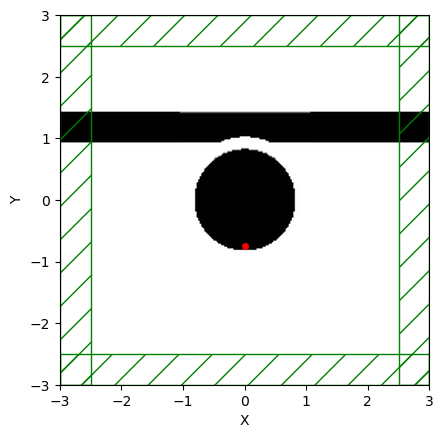

In [ ]:
size_bottom = flux_coord + wg_center_y - wg_width/2
coord_bottom = (-flux_coord + wg_center_y - wg_width/2)/2
size_top = flux_coord  - wg_center_y - wg_width/2
coord_top = (flux_coord + wg_center_y + wg_width/2)/2


Fields_in_WG = mpa.FourierFields(sim, 
            volume=mp.Volume(center=mp.Vector3(flux_coord, wg_center_y+1/Ny), size=mp.Vector3(0,wg_width)), 
            component=mp.Ez) #in wg r
Field_top = mpa.FourierFields(sim, 
            volume=mp.Volume(center=(flux_coord/2, flux_coord,0), size=(flux_coord, 0,0)), 
            component=mp.Ez) #top
            
Field_bottom = mpa.FourierFields(sim, 
            volume=mp.Volume(center=(flux_coord/2, -flux_coord,0), size=(flux_coord, 0,0)), 
            component=mp.Ez) #bottom
               

obj_args = [Fields_in_WG, Field_bottom, Field_top]


def J(dft_in, bottom, top):
    # Усреднение по координатам, сумма по всем частотам
    power_in = npa.sum(npa.mean(npa.absolute(dft_in)**2, axis=1))
    power_out_bottom = npa.sum(npa.mean(npa.absolute(bottom)**2, axis=1))
    power_out_top = npa.sum(npa.mean(npa.absolute(top)**2, axis=1))
    return power_in/(power_out_bottom+power_out_top)


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=obj_args,
    design_regions=[design_region],
    fcen=1/1.1,
    df=df,
    nf=20,
    maximum_run_time=2000,
)

plt.figure()
initial_config = np.zeros((Nx * Ny,))
initial_config = npa.where(wg_mask.flatten(), 1 ,initial_config) #WG
initial_config = npa.where(circle_pad_mask.flatten(), 0 ,initial_config) #pad around disk (distance)
initial_config = npa.where(circle_mask.flatten(), 1 ,initial_config) #pad around disk (distance)
opt.update_design([initial_config])
#opt.update_design([mapping(initial_config, eta_i, np.inf)])
opt.plot2D(False)
plt.show()



In [ ]:
# single iteration
f0, dJ = opt()
print(f0)

plt.figure()
plt.imshow(np.reshape(npa.sum(dJ, axis=1), (Nx,Ny)))
plt.show()

Starting forward run...


KeyboardInterrupt: 

## Оптимизация

In [5]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient
    
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    
    evaluation_history.append(np.real(f0))
    np.save(f"{foldername}/{file_name}_{cur_iter[0]}.npy",v)
    cur_iter[0] = cur_iter[0] + 1
    print(np.real(f0))
    return np.real(f0)

Current iteration: 1
Starting forward run...


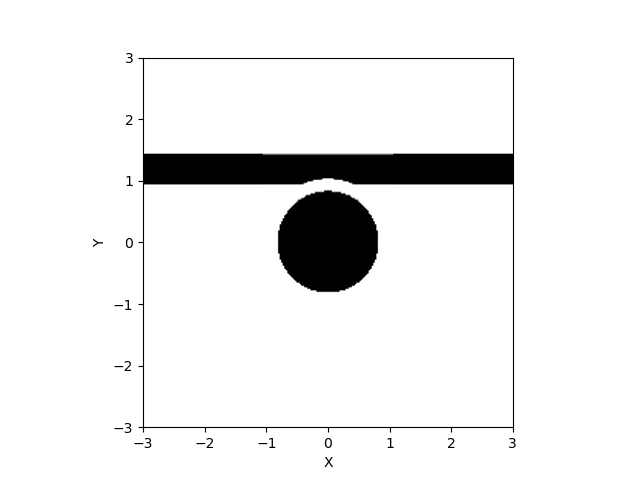

Starting adjoint run...
Calculating gradient...
35.08219221995632
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
35.19740554377874
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
35.659620642614385
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
36.324502525229455
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
35.06665066546945
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
37.00638400434322
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
36.653106780887725
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...
39.59725132087004
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
42.55218410558046
Current iteration: 10
Starting forward run.

In [ ]:
import nlopt
%matplotlib ipympl
# Create the animation
animate_step = mp.Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1, 'frequency': 1/wl},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    nb=True         # required if running in a Jupyter notebook
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate_step)]

algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = initial_config

# Продолжить с заданной итерации
#iter = 10
#x = np.load(f"{foldername}/{file_name}_{iter}.npy")
# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = np.inf
num_betas = 5
update_factor = 10
ftol = 1e-7
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)

np.save(f"{foldername}/{file_name}_design.npy", x)

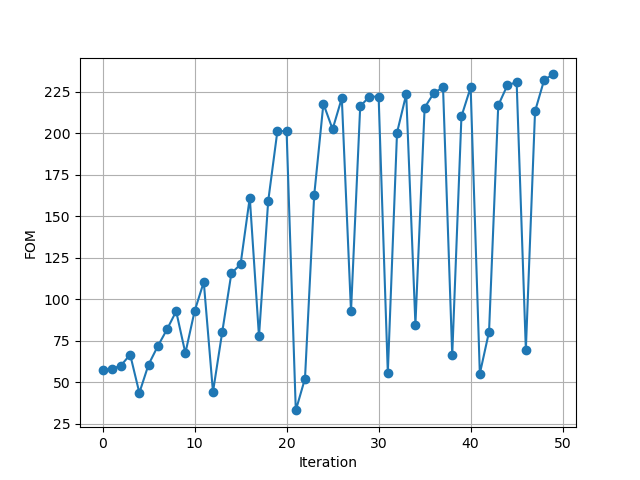

In [7]:
plt.figure()
plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
np.save(f"{foldername}/{file_name}_history.npy", np.array(evaluation_history))
plt.savefig(f"{foldername}/{file_name}_history.png")
plt.show()

## Сравнение

### Прогон обоих симуляций

In [8]:
# Координаты и размеры мониторов
# По умолчанию flux считается в положительном направлении оси, поэтому для мониторов слева и снизу нужно добавить weight=-1 чтобы значения складывались,а не вычитались

size_bottom = flux_coord + wg_center_y - wg_width/2
coord_bottom = (-flux_coord + wg_center_y - wg_width/2)/2
size_top = flux_coord  - wg_center_y - wg_width/2
coord_top = (flux_coord + wg_center_y + wg_width/2)/2

regions = {'in': [
    {'center': (flux_coord, wg_center_y, 0), 'size': (0,wg_width, 0)},
    {'center': (-flux_coord, wg_center_y, 0), 'size': (0,wg_width, 0), 'weight': -1}
       ],
'out': [
    {'center': (flux_coord, coord_bottom, 0), 'size': (0, size_bottom,0)},#right down
    {'center': (flux_coord, coord_top, 0), 'size': (0, size_top,0)}, #right up
    {'center': (-flux_coord, coord_bottom, 0), 'size': (0, size_bottom,0), 'weight': -1}, #left down
    {'center': (-flux_coord, coord_top, 0), 'size': (0, size_top,0), 'weight': -1}, #left up
    {'center': (0, -flux_coord, 0), 'size': (2*flux_coord, 0, 0),'weight': -1}, #bottom
    {'center': (0, flux_coord, 0), 'size': (2*flux_coord, 0, 0)}#top
]
}

wg_fluxes_reg = [mp.FluxRegion(**args) for args in regions['in']]
not_wg_fluxes_reg = [mp.FluxRegion(**args) for args in regions['out']]

In [9]:
# Инициализация симуляции, прогон, замер мощностей
# df_p_mon, df_q_mon - диапазоны частот мониторов мощности и добротности
# wg_fluxes_reg, not_wg_fluxes_reg - FluxRegion внутри и вне волновода
def test_structure(id_name, geometry, fcen, df_p_mon, df_q_mon, wg_fluxes_reg, not_wg_fluxes_reg):
    sim_temp = mp.Simulation(
        cell_size=mp.Vector3(sxy, sxy),
        sources=src,
        geometry=geometry,
        resolution=resolution,
        boundary_layers=[mp.PML(pml_thickness)],
        default_material=mp.Medium(index=air),
        symmetries=[mp.Mirror(direction=mp.X)],
    )
    sim_temp.reset_meep()
    # Добавление мониторов
    wg_fluxes = sim_temp.add_flux(fcen, df_p_mon, nfreq, *wg_fluxes_reg)
    not_wg_fluxes = sim_temp.add_flux(fcen, df_p_mon, nfreq, *not_wg_fluxes_reg)
    # Прогон
    wls, Qs = run_and_measure_Q(sim_temp, fcen, df_q_mon, [mp.Vector3(0,-0.75*wl/Si*r)], time)
    # Запись мощностей
    flux_wls = 1 / np.array(mp.get_flux_freqs(not_wg_fluxes)) # частоты 
    flux_in_wg = np.array(mp.get_fluxes(wg_fluxes)) # внутри волновода 
    flux_out_wg = np.array(mp.get_fluxes(not_wg_fluxes)) # вне волновода
    # Plot geometry
    plt.figure()
    sim_temp.plot2D()
    plt.savefig(f'{foldername}/{file_name}_{id_name}_geom.png')
    plt.show()
    # Plot Ez field
    plt.figure()
    sim_temp.plot2D(fields=mp.Ez)
    plt.savefig(f'{foldername}/{file_name}_{id_name}_Ez.png')
    plt.show()

    return {'wls': flux_wls, 'in': flux_in_wg, 'out': flux_out_wg, 'res_wls': wls, 'Qs': Qs}

    

# Функция для измерения добротности
# fcen центральная частота монитора
# df_q частотный диапазон монитора
# coordinates список координат мониторов
# time 
def run_and_measure_Q(simulation, fcen, df_q, coordinates, time):
    #simulation.reset_meep()
    harminv_monitor = [mp.Harminv(mp.Ez, с, fcen, df_q) for с in coordinates]
    # Run
    simulation.run(mp.after_sources(*harminv_monitor), until_after_sources=time)
    
    wls = []
    Qs = []
    for c, h in zip(coordinates, harminv_monitor):
        wls.append([np.round(1/m.freq,2) for m in h.modes])
        Qs.append([np.round(m.Q,1) for m in h.modes])
    return wls, Qs

    

#fluxes, labels должны быть списками из мощностей и соответствующих им названий одинаковой длины
def plot_fluxes(title, wls, fluxes, labels, filename):
    plt.figure()
    plt.title(title)
    for f, l in zip(fluxes, labels):
        plt.plot(wls, f, 'o-', label=l)
    plt.xlabel("wavelength (μm)")
    plt.legend()
    plt.savefig(f'{foldername}/{file_name}_{filename}.png')
    plt.show()


FloatProgress(value=0.0, description='0% done ', max=700.0)

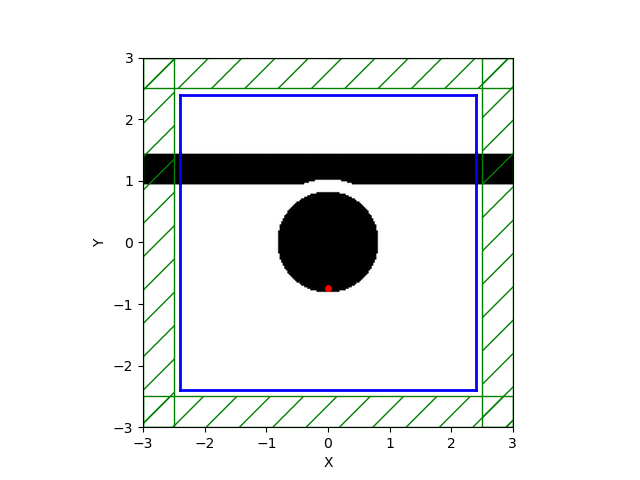

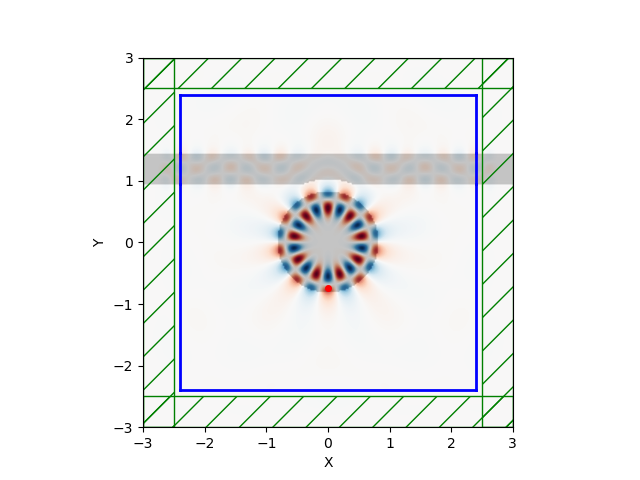

FloatProgress(value=0.0, description='0% done ', max=700.0)

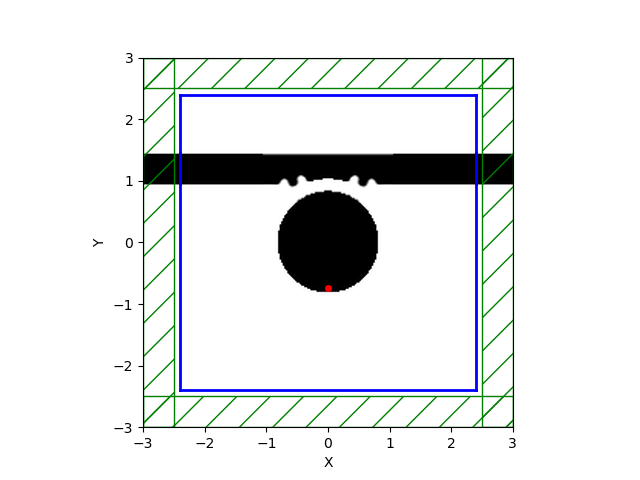

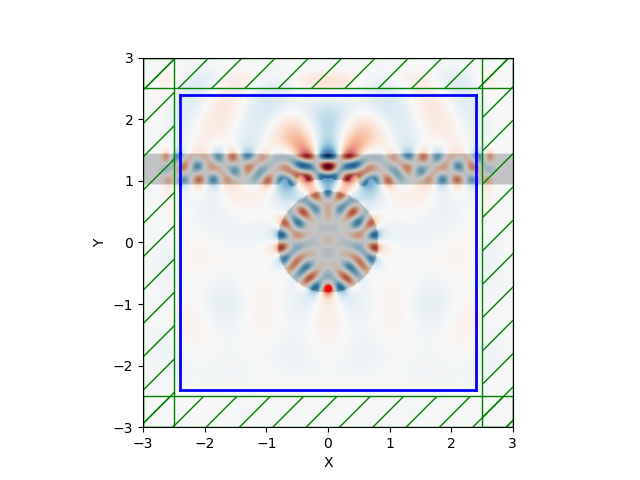

In [10]:
df_p_mon = 0.03
df_q_mon = 0.05

#Чтение структуры из файла на заданной итерации
iter = 18
x = np.load(f"{foldername}/{file_name}_{iter}.npy")
ref_geometry = init_geometry(True, angle, distance)
opt_geometry = init_geometry(True, angle, distance)
opt_geometry.append(mp.Block(center=design_region.center, size=design_region.size, material=design_variables))
design_region.update_design_parameters(mapping(x, eta_i, np.inf))


# ref, opt имеют вид {'wls': flux_wls, 'in': flux_in_wg, 'out': flux_out_wg, 'res_wls': wls, 'Qs': Qs}
ref = test_structure('ref', ref_geometry, fcen, df_p_mon, df_q_mon, wg_fluxes_reg, not_wg_fluxes_reg)
opt = test_structure('opt', opt_geometry, fcen, df_p_mon, df_q_mon, wg_fluxes_reg, not_wg_fluxes_reg)



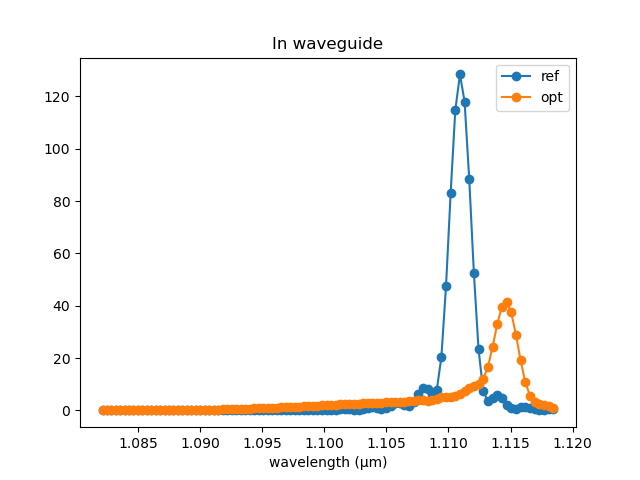

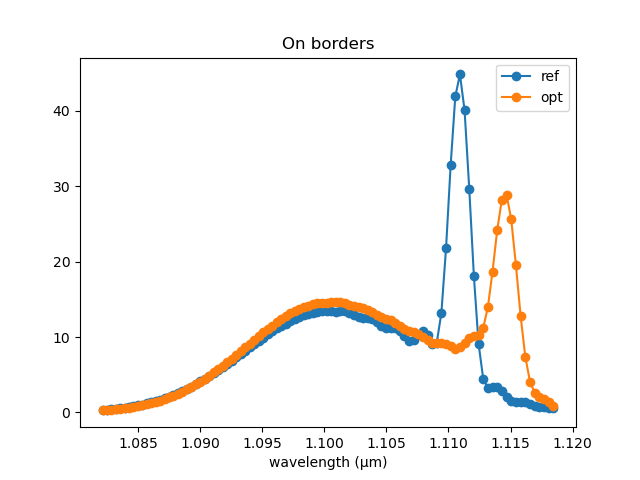

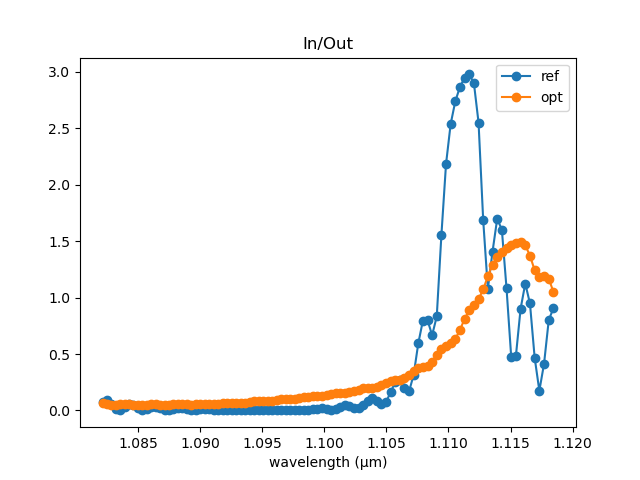

In [13]:
# title, x, [y1, y2,...], [y1_label, y2_label,...], filename
plot_fluxes('In waveguide', ref['wls'], [ref['in'], opt['in']], ['ref','opt'], 'in')
plot_fluxes('On borders', ref['wls'], [ref['out'], opt['out']], ['ref','opt'], 'out')
plot_fluxes('In/Out', ref['wls'], [ref['in']/ref['out'], opt['in']/opt['out']], ['ref','opt'], 'ratio')

In [12]:
print('Ref:')
print('Резонансные длины волн:')
print(ref['res_wls'])
print('Добротности:')
print(ref['Qs'])
print('Opt:')
print('Резонансные длины волн:')
print(opt['res_wls'])
print('Добротности:')
print(opt['Qs'])

Ref:
Резонансные длины волн:
[[1.11]]
Добротности:
[[1301.0]]
Opt:
Резонансные длины волн:
[[1.11, 1.11, 1.08]]
Добротности:
[[613.3, 55.8, 52.8]]
